In [55]:
import json

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
import tensorflow.keras.layers as L
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.random.set_seed(2020)
np.random.seed(2020)

In [56]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']
y_true = tf.random.normal((32, 68, 3))
y_pred = tf.random.normal((32, 68, 3))

In [57]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)



def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(
        hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))



def build_model(embed_size, seq_len=107, pred_len=68, dropout=0.5, 
                sp_dropout=0.2, embed_dim=200, hidden_dim=256, n_layers=3):
    inputs = L.Input(shape=(seq_len, 3))
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3])
    )
    hidden = L.SpatialDropout1D(sp_dropout)(reshaped)
    
    for x in range(n_layers):
        hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    # Since we are only making predictions on the first part of each sequence, 
    # we have to truncate it
    truncated = hidden[:, :pred_len]
    out = L.Dense(5, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(tf.optimizers.Adam(), loss=MCRMSE)
    
    return model



def pandas_list_to_array(df):
    return np.transpose(
        np.array(df.values.tolist()),
        (0, 2, 1)
    )



def preprocess_inputs(df, token2int, cols=['sequence', 'structure', 'predicted_loop_type']):
    return pandas_list_to_array(
        df[cols].applymap(lambda seq: [token2int[x] for x in seq])
    )

In [58]:
train = pd.read_json('train.json', lines=True)
test = pd.read_json('test.json', lines=True)
sample_df = pd.read_csv('sample_submission.csv')

train = train.query("signal_to_noise >= 1")

In [60]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
train_inputs = preprocess_inputs(train, token2int)
train_labels = pandas_list_to_array(train[pred_cols])

x_train, x_val, y_train, y_val = train_test_split(train_inputs,
                                                  train_labels,
                                                  test_size=.1,
                                                  random_state=34,
                                                  stratify=train.SN_filter)

public_df = test.query("seq_length == 107")
private_df = test.query("seq_length == 130")

public_inputs = preprocess_inputs(public_df, token2int)
private_inputs = preprocess_inputs(private_df, token2int)

In [62]:
model = build_model(embed_size=len(token2int))

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=100,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=5),
        tf.keras.callbacks.ModelCheckpoint('model.h5')
    ]
)

Epoch 1/100
30/30 - 4s - loss: 0.4633 - val_loss: 0.3857
Epoch 2/100
30/30 - 3s - loss: 0.3904 - val_loss: 0.3623
Epoch 3/100
30/30 - 3s - loss: 0.3663 - val_loss: 0.3439
Epoch 4/100
30/30 - 3s - loss: 0.3506 - val_loss: 0.3266
Epoch 5/100
30/30 - 3s - loss: 0.3382 - val_loss: 0.3212
Epoch 6/100
30/30 - 3s - loss: 0.3306 - val_loss: 0.3200
Epoch 7/100
30/30 - 3s - loss: 0.3235 - val_loss: 0.3069
Epoch 8/100
30/30 - 3s - loss: 0.3129 - val_loss: 0.2978
Epoch 9/100
30/30 - 3s - loss: 0.3082 - val_loss: 0.2941
Epoch 10/100
30/30 - 3s - loss: 0.3010 - val_loss: 0.2864
Epoch 11/100
30/30 - 3s - loss: 0.2958 - val_loss: 0.2862
Epoch 12/100
30/30 - 3s - loss: 0.2913 - val_loss: 0.2769
Epoch 13/100
30/30 - 3s - loss: 0.2842 - val_loss: 0.2723
Epoch 14/100
30/30 - 3s - loss: 0.2763 - val_loss: 0.2641
Epoch 15/100
30/30 - 3s - loss: 0.2698 - val_loss: 0.2579
Epoch 16/100
30/30 - 3s - loss: 0.2630 - val_loss: 0.2514
Epoch 17/100
30/30 - 3s - loss: 0.2593 - val_loss: 0.2540
Epoch 18/100
30/30 - 3s

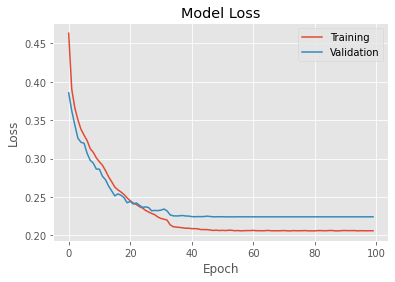

In [63]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [65]:
model_public = build_model(seq_len=107, pred_len=107, embed_size=len(token2int))
model_private = build_model(seq_len=130, pred_len=130, embed_size=len(token2int))

model_public.load_weights('model.h5')
model_private.load_weights('model.h5')

public_preds = model_public.predict(public_inputs)
private_preds = model_private.predict(private_inputs)

In [66]:
preds_ls = []

for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)

submission = sample_df[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
submission.to_csv('submission.csv', index=False)